## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

## Importing Dataset & Fixing Columng

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
df_ = pd.read_csv('Telco-Customer-Churn_2.csv')
df = df_.copy()

TARGET = 'Churn'

df['TotalCharges'] = df['tenure']*df['MonthlyCharges']

## Task 1: Exploratory Data Analytics

### Step 1:  Examine the overall picture.

In [3]:
def check_df(dataframe, head = 5):

    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### nunique #####################")
    print(dataframe.nunique())

check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object
##################### NA #####################
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        

### Step 2: Capture numeric and categorical variables.

In [4]:
def grab_col_names(dataframe, target, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.   

    Parameters
    ------
        dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
        target: str
                Dependent (target) variable

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols_mask = [col for col in dataframe.columns if dataframe[col].dtypes == "O"
                     and dataframe[col].nunique() < car_th and col != target]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O"
                   and dataframe[col].nunique() < cat_th and col != target]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and
                   col not in cat_cols_mask and col != target]

    cat_cols = cat_cols_mask + num_but_cat

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"
                and col not in num_but_cat and col != target]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, TARGET, cat_th=20)

Observations: 7043
Variables: 21
cat_cols: 16
num_cols: 3
cat_but_car: 1
num_but_cat: 1


### Step 3: Analyze numeric and categorical variables.

Numerical columns:

In [5]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043.0,2279.581350,2264.729447,0.00,394.0,1393.60,3786.10,8550.00


count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


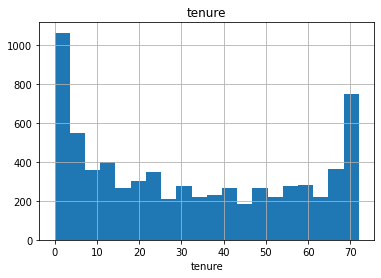

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


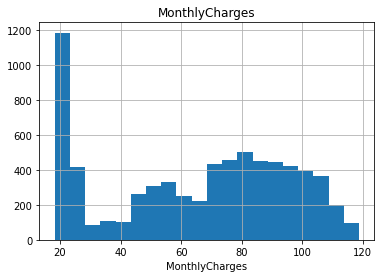

count    7043.000000
mean     2279.581350
std      2264.729447
min         0.000000
25%       394.000000
50%      1393.600000
75%      3786.100000
max      8550.000000
Name: TotalCharges, dtype: float64


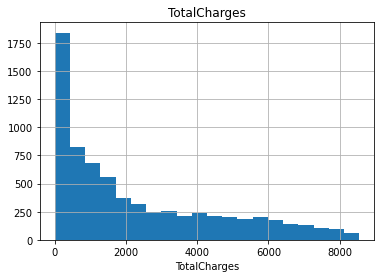

In [6]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.25, 0.50, 0.75]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

Categorical columns:

        gender     Ratio
Male      3555  50.47565
Female    3488  49.52435
##########################################


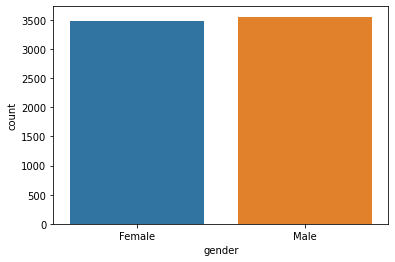

     Partner     Ratio
No      3641  51.69672
Yes     3402  48.30328
##########################################


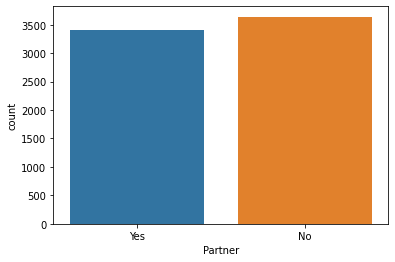

     Dependents      Ratio
No         4933  70.041176
Yes        2110  29.958824
##########################################


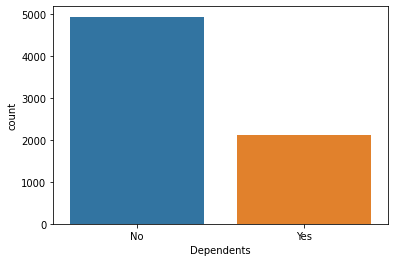

     PhoneService      Ratio
Yes          6361  90.316626
No            682   9.683374
##########################################


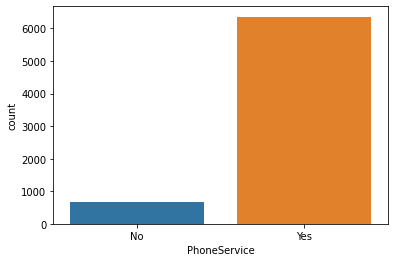

                  MultipleLines      Ratio
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
##########################################


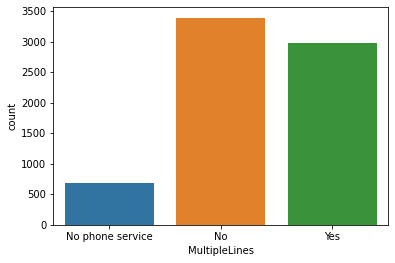

             InternetService      Ratio
Fiber optic             3096  43.958540
DSL                     2421  34.374556
No                      1526  21.666903
##########################################


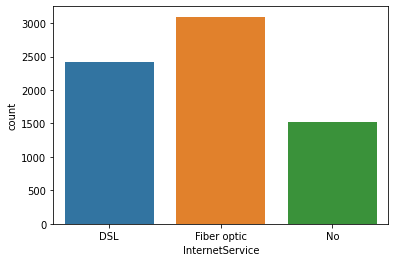

                     OnlineSecurity      Ratio
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903
##########################################


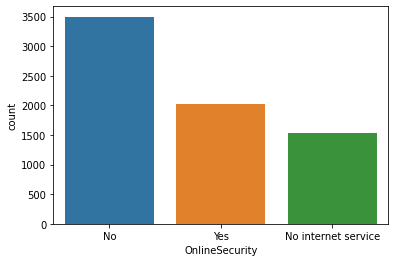

                     OnlineBackup      Ratio
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903
##########################################


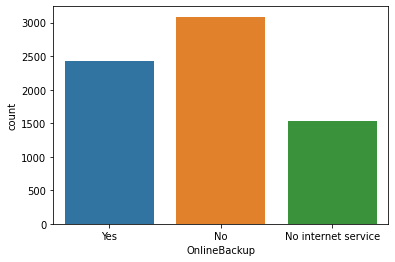

                     DeviceProtection      Ratio
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903
##########################################


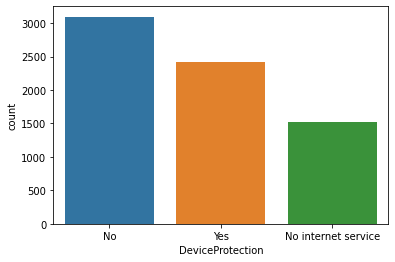

                     TechSupport      Ratio
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903
##########################################


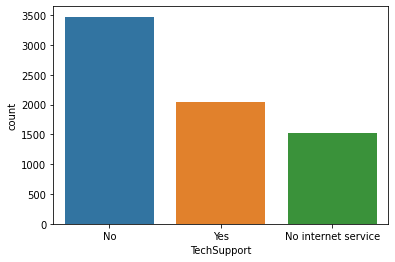

                     StreamingTV      Ratio
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903
##########################################


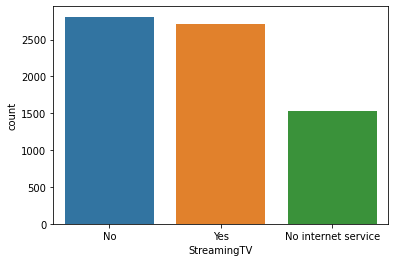

                     StreamingMovies      Ratio
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903
##########################################


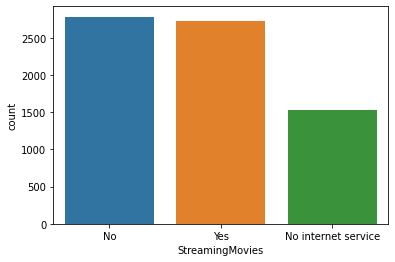

                Contract      Ratio
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
##########################################


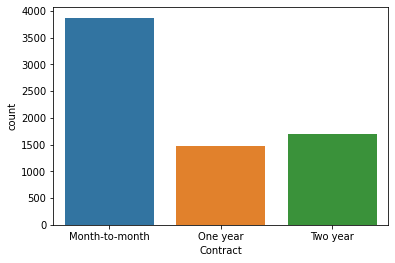

     PaperlessBilling      Ratio
Yes              4171  59.221922
No               2872  40.778078
##########################################


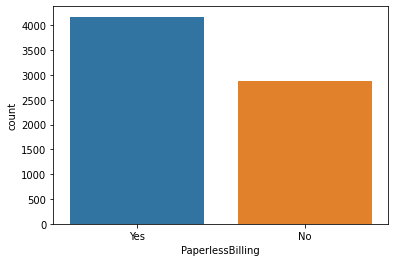

                           PaymentMethod      Ratio
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
##########################################


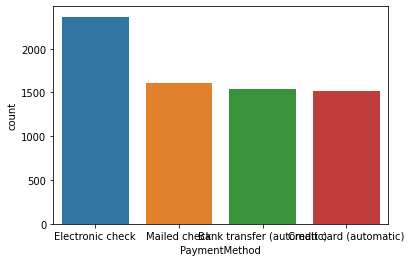

   SeniorCitizen      Ratio
0           5901  83.785319
1           1142  16.214681
##########################################


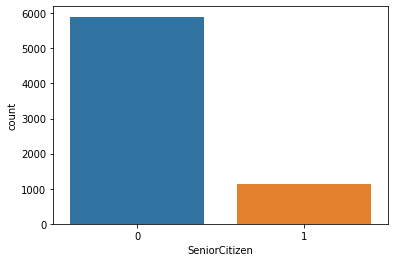

In [7]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

## Task 2: Data Pre-Processing

### Step 1: Analyze and handle missing observations.

In [8]:
def missing_values_table(dataframe, na_name=False):
    '''
    This Python function, missing_values_table, is designed to provide a summary of missing values in a DataFrame

    Parameters:
    dataframe: The DataFrame for which you want to analyze missing values.
    na_name (default False): A boolean flag that, when set to True, returns a list of column names with missing values.
    '''
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [9]:
features_with_missing = missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


### Step 2: Conduct outlier analysis and handle them.

In [10]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    '''
    This function calculates the lower and upper bounds for identifying outliers in a specified column of a DataFrame.

    Parameters:
    dataframe: The DataFrame containing the data.
    col_name: The name of the column for which you want to calculate outlier thresholds.
    q1 (default 0.25): The lower quartile (25th percentile) value used to calculate the lower limit.
    q3 (default 0.75): The upper quartile (75th percentile) value used to calculate the upper limit.
    '''

    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, print_values=False):
    '''
    This function checks for outliers in a specified column of a DataFrame using the thresholds calculated by the outlier_thresholds function.

    Parameters:
    dataframe: The DataFrame containing the data.
    col_name: The name of the column to check for outliers.
    print_values (default False): A boolean flag indicating whether to print the actual outlier values if any are found.
    '''

    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95)
    if dataframe[(dataframe[col_name] > up_limit) |
                 (dataframe[col_name] < low_limit)].any(axis=None):
        if print_values:
            print(f'Values with higher values than upper limit in {col_name}:\n'
                  f'{dataframe.loc[dataframe[col_name] > up_limit, col_name]}\n')
            print(f'Values with lower values than lower limit in {col_name}:\n'
                  f'{dataframe.loc[dataframe[col_name] < low_limit, col_name]}\n',)
        else:
            print(f'There is outlined data in {col_name}')
        return True
    else:
        print(f'There is no outlined data in {col_name}')
        return False

In [11]:
for col in df[num_cols].columns:
    check_outlier(df, col, print_values=True)

There is no outlined data in tenure
There is no outlined data in MonthlyCharges
There is no outlined data in TotalCharges


There are no missing values or outliers, so the preprocessing of the data is finished here, but: 
1. If outliers were detected, we would have 2 different options:
- Outliers could have been suppressed to quartiles.
- Observations with outliers could have been discarded directly from the dataframe.
2. If missing values were captured, we would have 3 different options:
- Observations with missing values would be deleted directly from the observation.
- The missing values could be assigned the median or mode value of the variable (column) they are in.
- With a modeling such as K-nearest neighbor, the observations close to the observation with the missing value would be identified and the values in similar observations could be assigned to this missing value.

## Task 3: Feature Engineering

### Step 1: Creating new features

In [12]:
df.loc[(df['Partner'] == 'No') & (df['Dependents'] == 'No'), 'NEW_IS_ALONE'] = 'Yes'
df.loc[(df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes'), 'NEW_IS_ALONE'] = 'No'

df.loc[(df['OnlineSecurity'] == 'Yes') & (df['OnlineBackup'] == 'Yes') &
       (df['DeviceProtection'] == 'Yes'), 'NEW_IS_CAUTIOUS'] = 'Yes'
df.loc[(df['OnlineSecurity'] != 'Yes') | (df['OnlineBackup'] != 'Yes') |
       (df['DeviceProtection'] != 'Yes'), 'NEW_IS_CAUTIOUS'] = 'No'

df.loc[(df['SeniorCitizen'] == 1) & (df['TechSupport'] == 'Yes'), 'NEW_IS_HELPLESS'] = 'Yes'
df.loc[(df['SeniorCitizen'] == 0) | (df['TechSupport'] != 'Yes'), 'NEW_IS_HELPLESS'] = 'No'

df['tenure_MonthlyCharges_Ratio'] = df['tenure'] / df['MonthlyCharges']

### Step 2: Label Encoding

Binary encoding

In [13]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

One hot encoding

In [14]:
for col in cat_cols:
    if col not in binary_cols:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

### Step 3: Standardization of numeric features.

In [15]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

## Task 3: Machine Learning Model Process

### Step 1: Chosing the best Machine Learning model for the data-set:

In [16]:
def check_test_scores(results):
    print(f'test accuracy score: {results["test_accuracy"].mean()}')
    print(f'test roc_auc score: {results["test_roc_auc"].mean()}')
    print(f'test recall score: {results["test_recall"].mean()}')
    print(f'test precision score: {results["test_precision"].mean()}')
    print(f'test f1 Score: {results["test_f1"].mean()}')

y = df[TARGET]
X = df.drop([TARGET, 'customerID'], axis=1)

for alg in [RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier]:

    model = alg(random_state=33)
    if alg == CatBoostClassifier:
        model = alg(random_state=33, verbose=False)
    cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'f1',
                                                                'precision', 'recall', 'roc_auc'])
    print(f'-----------Scores of {alg}-----------')
    check_test_scores(cv_results)

-----------Scores of <class 'sklearn.ensemble._forest.RandomForestClassifier'>-----------
test accuracy score: 0.7888699472546616
test roc_auc score: 0.8237697319009627
test recall score: 0.4729767315163941
test precision score: 0.6386211281553382
test f1 Score: 0.54330189632985
-----------Scores of <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>-----------
test accuracy score: 0.8059067318859281
test roc_auc score: 0.8471431115214958
test recall score: 0.5259465814110192
test precision score: 0.6720572643884717
test f1 Score: 0.5899855266345833
-----------Scores of <class 'xgboost.sklearn.XGBClassifier'>-----------
test accuracy score: 0.7836170881992387
test roc_auc score: 0.8239781806994417
test recall score: 0.508829980932173
test precision score: 0.6115368080344219
test f1 Score: 0.5553112534307895
-----------Scores of <class 'lightgbm.sklearn.LGBMClassifier'>-----------
test accuracy score: 0.793270130330989
test roc_auc score: 0.832422042279024
test recall score: 0.514

Best Models: Gradient Boosting, Catboost, LGBM

### Step 2: Fine tuning on best model

In [17]:
# LGBM

print('--- LGBM Starts ---')

lgbm_model = LGBMClassifier(random_state=33)
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results_lgbm = cross_validate(lgbm_final, X, y, cv=5, scoring=['accuracy', 'f1',
                                                                'precision', 'recall', 'roc_auc'])
print("LGBM done")

# CatBoost

print('--- CatBoost Starts ---')

catboost_model = CatBoostClassifier(random_state=33, verbose=False)
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=False).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results_cat = cross_validate(catboost_final, X, y, cv=5, scoring=['accuracy', 'f1',
                                                                'precision', 'recall', 'roc_auc'])
print("CatBoost done")

# GradientBoosting

print('--- GradientBoosting Starts ---')

gbm_model = GradientBoostingClassifier(random_state=33)
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [100, 500],
              "subsample": [1, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results_gbm = cross_validate(gbm_final, X, y, cv=5, scoring=['accuracy', 'f1',
                                                                'precision', 'recall', 'roc_auc'])
print("GBM done")

--- LGBM Starts ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
LGBM done
--- CatBoost Starts ---
CatBoost done
--- GradientBoosting Starts ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
GBM done


Test scores of tuned model:

In [18]:
print('------LGBM------')
check_test_scores(cv_results_lgbm)
print('------CAT------')
check_test_scores(cv_results_cat)
print('------GBM------')
check_test_scores(cv_results_gbm)

------LGBM------
test accuracy score: 0.8024990523582167
test roc_auc score: 0.8433919809487609
test recall score: 0.5029404596349873
test precision score: 0.6712758916975815
test f1 Score: 0.5749355215599057
------CAT------
test accuracy score: 0.8067587021743339
test roc_auc score: 0.8488458920347115
test recall score: 0.5147137675445513
test precision score: 0.6799748840713349
test f1 Score: 0.585793385404401
------GBM------
test accuracy score: 0.8053384492547906
test roc_auc score: 0.8485727653735184
test recall score: 0.513642815156772
test precision score: 0.6750759587488561
test f1 Score: 0.5833617315869335


Feature Importance of the tuned best models:

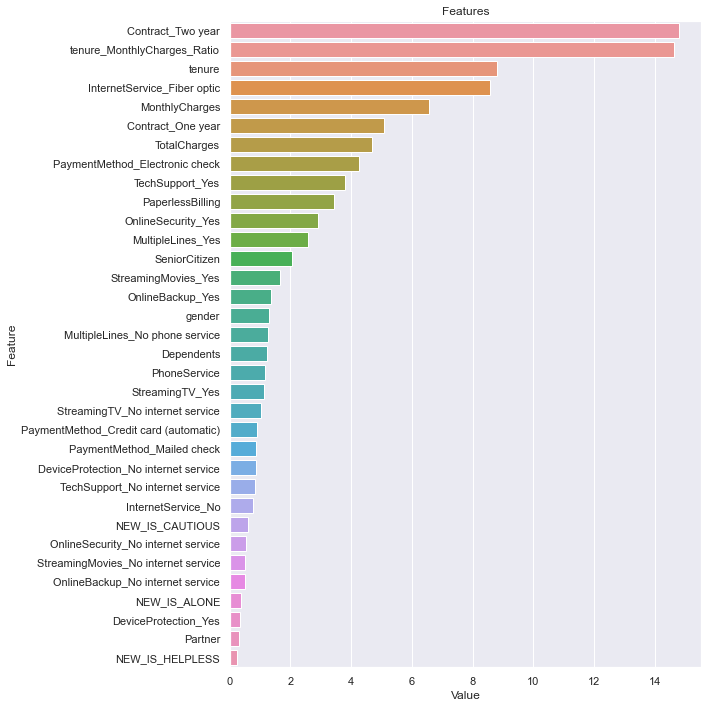

In [19]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(catboost_final, X)